# Classifying SNe

`Authors: Carolina Núñez, Vicente Pedreros, Antonio Vitalic`

The Dark Energy Science Collaboration released a new dataset with simulated light curves from LSST, including many classes of transient and persistent sources, including light curves and host information: [training set](https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/#trainingset)

In this project you are asked to build a classifier that can discriminate between the three classes of SNe: SNII (SNII-Templates, SNII-HostXT_V19 and SNII-NMF), SNIa (SNIa-91bg, SNIa-SALT2 and SNIax) and SNIbc (SNIb+HostXT_V19, SNIb-Templates, SNIc+HostXT_V19, SNIc-Templates, SNIcBL+HostXT_V19).
You can use metadata and light curve information.


Basic libraries are imported. Note that `Table` is used to transform the fits files to a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import fnmatch, glob

# Display all columns of pandas dataframe
pd.set_option('display.max_columns', None)

## Curating the data

The first thing to do is import the data. The function `to_df` will recieve the path to the first model of each class and return a dataframe. Note that the columns corresponding to the simulation data are dropped.

In [2]:
head_filenames = fnmatch.filter(glob.glob('data_rn/*'), '*HEAD.FITS.gz')
classes = ['SNIa', 'SNIbc', 'SNII']  # These are the classes that will be classified

In [3]:
def to_df(filename):
    """
    This function recieves a filename and will create a dataframe by using the HEAD's and PHOT's files.
    The columns corresponding to simulation information are droppped.
    """
    cl = filename.replace('_HEAD.FITS.gz', '').replace('data_rn/', '')  # Name of the class
    for _class_ in classes:
        if _class_ in cl:
            cl = _class_
        elif 'SNIc' in cl or 'SNIb' in cl:
            cl = 'SNIbc'

    df_train = Table.read(filename, format='fits').to_pandas()
    for col in ['SNID', 'IAUC', 'SIM_MODEL_NAME', 'SIM_TYPE_NAME']:
        df_train[col] = df_train[col].apply(lambda row: row.decode("utf-8").strip())
    
    df_lc = Table.read(filename.replace("HEAD", "PHOT"), format='fits').to_pandas()
    for col in ['BAND', 'FIELD']:
        df_lc[col] = df_lc[col].apply(lambda row: row.decode("utf-8").strip())

    # The data from HEAD and PHOT are grouped.
    df = df_train.groupby("SNID").apply(lambda df: df_lc.iloc[df.PTROBS_MIN.iloc[0]-1:df.PTROBS_MAX.iloc[0]-1]).reset_index()
    df = pd.merge(df_train, df, left_on='SNID', right_on='SNID')
    
    # Simulation information is dropped
    SIM_cols = [col for col in df.columns if 'SIM' in col]
    df = df.drop(SIM_cols, axis=1)

    # A column containing the name of the class is added
    s = [cl for x in range(len(df))] # Array of strings containing the name of the class
    df.insert(0, 'CLASS', s)
    return df


In [4]:
dataframes = []

for fn in head_filenames:
    dataframes.append(to_df(fn))

df_train = pd.concat(dataframes)
df_train

,CLASS,SNID,IAUC,FAKE,RA,DEC,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,PTROBS_MAX,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,REDSHIFT_FINAL,REDSHIFT_FINAL_ERR,VPEC,VPEC_ERR,HOSTGAL_NMATCH,HOSTGAL_NMATCH2,HOSTGAL_OBJID,HOSTGAL_FLAG,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_DDLR,HOSTGAL_CONFUSION,HOSTGAL_LOGMASS,HOSTGAL_LOGMASS_ERR,HOSTGAL_LOGSFR,HOSTGAL_LOGSFR_ERR,HOSTGAL_LOGsSFR,HOSTGAL_LOGsSFR_ERR,HOSTGAL_COLOR,HOSTGAL_COLOR_ERR,HOSTGAL_ELLIPTICITY,HOSTGAL_OBJID2,HOSTGAL_SQRADIUS,HOSTGAL_OBJID_UNIQUE,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_MAGERR_Y,HOSTGAL2_OBJID,HOSTGAL2_FLAG,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_DDLR,HOSTGAL2_LOGMASS,HOSTGAL2_LOGMASS_ERR,HOSTGAL2_LOGSFR,HOSTGAL2_LOGSFR_ERR,HOSTGAL2_LOGsSFR,HOSTGAL2_LOGsSFR_ERR,HOSTGAL2_COLOR,HOSTGAL2_COLOR_ERR,HOSTGAL2_ELLIPTICITY,HOSTGAL2_OBJID2,HOSTGAL2_SQRADIUS,HOSTGAL2_OBJID_UNIQUE,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL_SB_FLUXCAL_u,HOSTGAL_SB_FLUXCAL_g,HOSTGAL_SB_FLUXCAL_r,HOSTGAL_SB_FLUXCAL_i,HOSTGAL_SB_FLUXCAL_z,HOSTGAL_SB_FLUXCAL_Y,PEAKMJD,MJD_TRIGGER,MJD_DETECT_FIRST,MJD_DETECT_LAST,SEARCH_TYPE,level_1,MJD,BAND,CCDNUM,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,PSF_SIG2,PSF_RATIO,SKY_SIG,SKY_SIG_T,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN,XPIX,YPIX
0,SNIa,27528421,NULL,2,64.849535,-14.710349,0.2,-9,-9,111,117,1,117,0.035791,0.001790,0.423353,0.03838,0.423025,0.03838,0.0,300.0,1,1,10437689303,0,0.423353,0.03838,-9.0,-9.0,64.848976,-14.710298,0.756289,1.267039,-99.0,8.0517,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.8084,-9,31.145201,-9,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,0.499851,1.424683,4.087862,5.356892,6.207910,6.878313,61104.160156,61102.031250,61102.031250,61102.031250,-9,0,60895.4269,Y,-9,VOID,0,-9.0,-27.043575,33.173176,2.07,0.0,0.0,48.169998,0.0,0.25,30.070000,0.005,1.0,-9.0,-9.0
1,SNIa,27528421,NULL,2,64.849535,-14.710349,0.2,-9,-9,111,117,1,117,0.035791,0.001790,0.423353,0.03838,0.423025,0.03838,0.0,300.0,1,1,10437689303,0,0.423353,0.03838,-9.0,-9.0,64.848976,-14.710298,0.756289,1.267039,-99.0,8.0517,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.8084,-9,31.145201,-9,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,0.499851,1.424683,4.087862,5.356892,6.207910,6.878313,61104.160156,61102.031250,61102.031250,61102.031250,-9,1,60896.4165,Y,-9,V

### Visualization of data

A count plot and lighcurves (20 per class) are presented.

In [5]:
ax = df_train.groupby(['SNID']).max().value_counts().plot.bar()

Text(0.5, 1.0, 'Count plot of each class')

In [7]:
colors = {'u': 'b', 'g': 'g', 'r': 'r', 'i': 'orange', 'z': 'brown', 'Y': 'k'}

bands = ['HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r',
         'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y',]

bands2 = ['HOSTGAL2_MAG_u', 'HOSTGAL2_MAG_g', 'HOSTGAl2_MAG_r',
         'HOSTGAL2_MAG_i', 'HOSTGAL2_MAG_z', 'HOSTGAL2_MAG_Y',]


errors= ['HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r',
         'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y']

errors2= ['HOSTGA2_MAGERR_u', 'HOSTGAL2_MAGERR_g', 'HOSTGAL2_MAGERR_r',
         'HOSTGA2_MAGERR_i', 'HOSTGAL2_MAGERR_z', 'HOSTGAL2_MAGERR_Y']

In [8]:
def plot_lc(SNID, df, path=None):
    fig, ax = plt.subplots(figsize=(8,3))
    for idx, c in enumerate(colors.keys()):
      mask = (df.SNID == str(SNID)) & (df.BAND == c)
      if mask.sum() > 0:
        ax.errorbar(df.loc[mask].MJD, df.loc[mask].FLUXCAL,
                      yerr=df.loc[mask].FLUXCALERR, color=list(colors.values())[idx], fmt='o', ms=3, lw=0, elinewidth=1, label=c)

    ax.set_xlabel('mjd')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.set_title(str(SNID) + ' ' + df.loc[mask].iloc[0].CLASS)
    if path is not None: fig.savefig(path+'lc_'+SNID+'.png')

In [9]:
# Obtaining the samples

np.random.seed(73)

snids = []  # In this array, the snid's of the objects will be stored.

for i in range(len(df_train.CLASS.unique())):
    snids.append(
        list(df_train.loc[df_train['CLASS'].isin([df_train.CLASS.unique()[i]])].sample(10).SNID))

snids = sum(snids, [])  # Transform list of lists into a list containing each snid

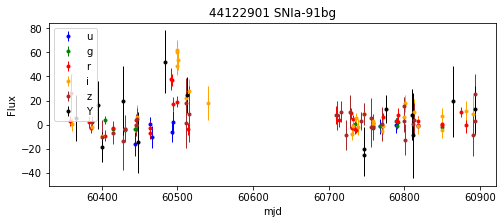

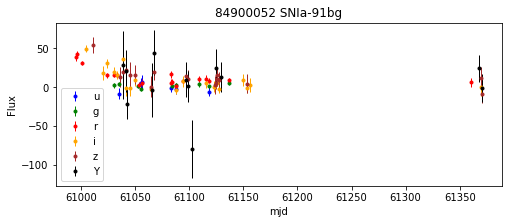

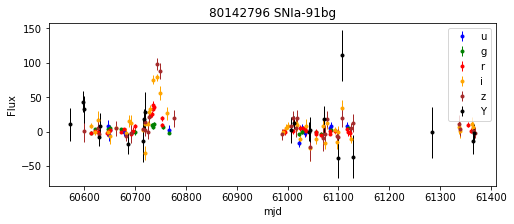

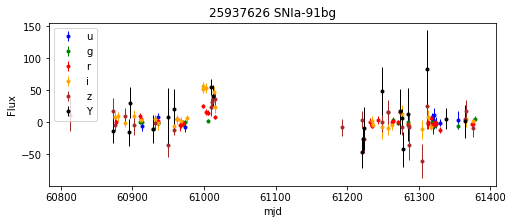

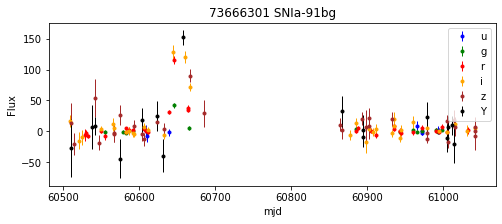

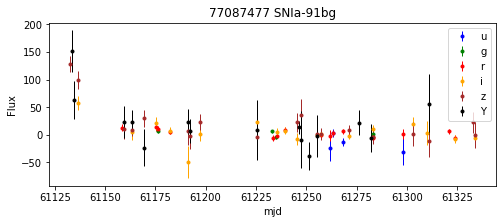

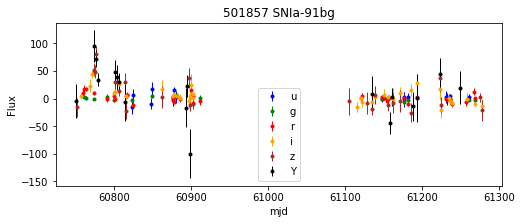

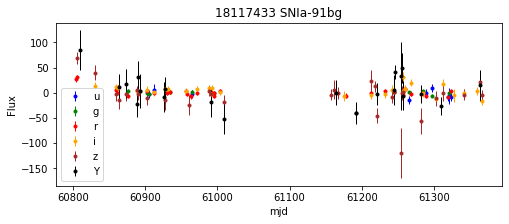

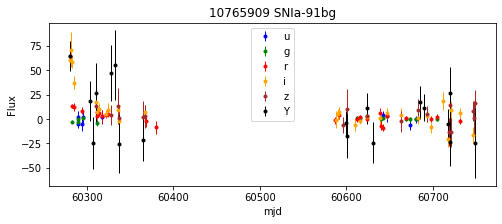

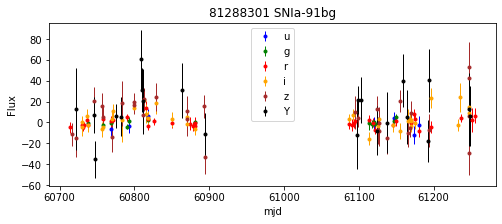

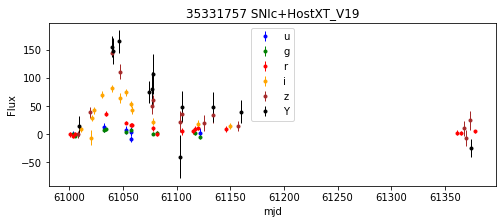

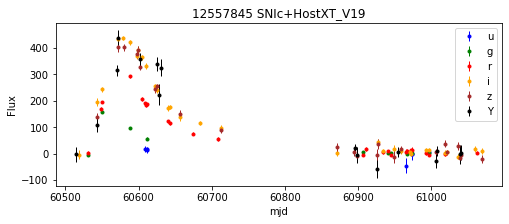

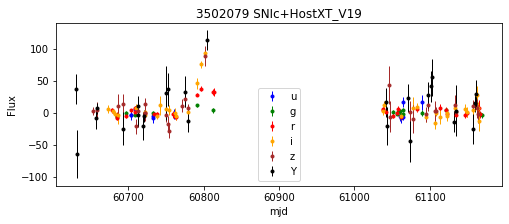

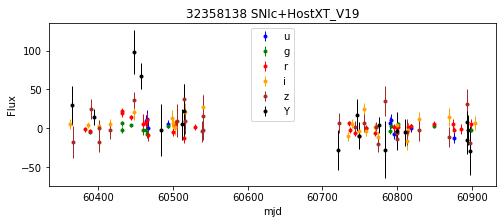

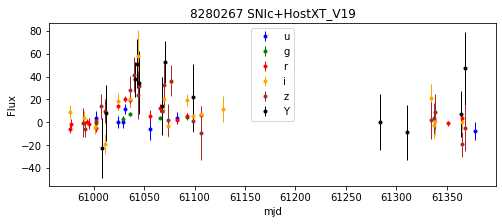

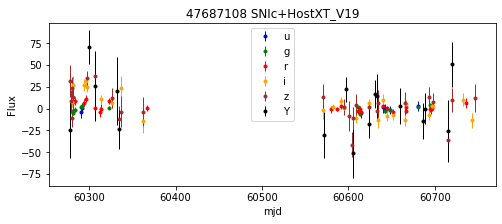

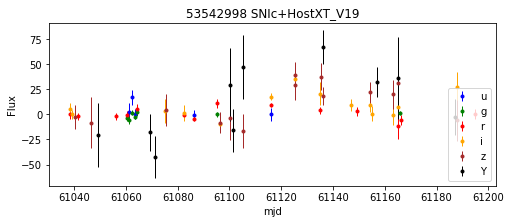

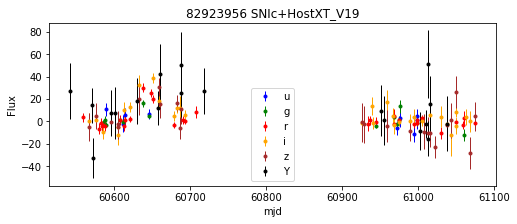

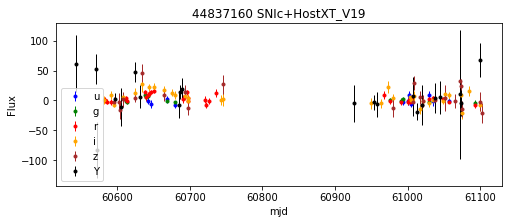

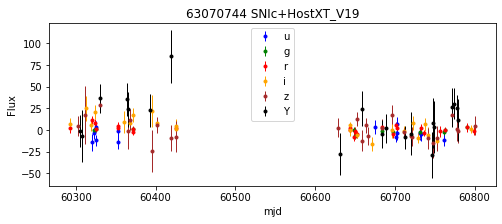

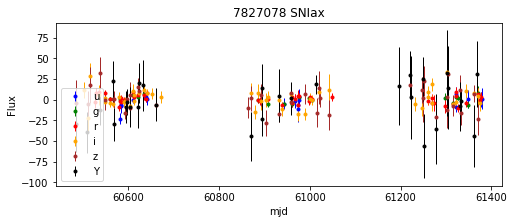

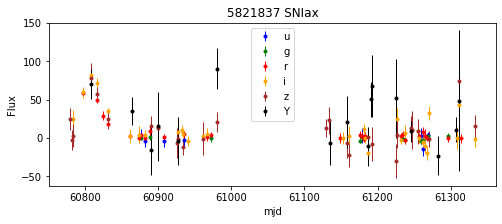

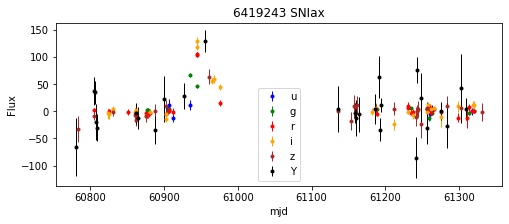

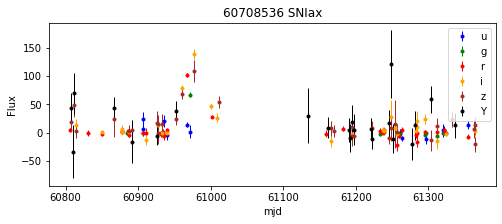

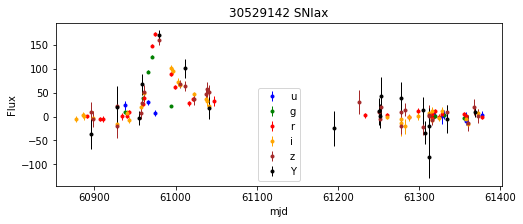

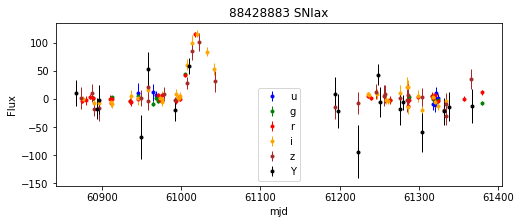

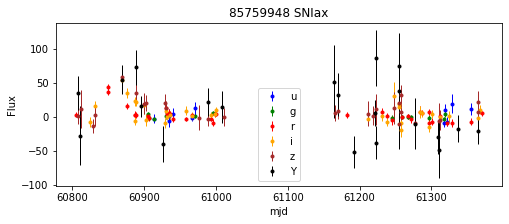

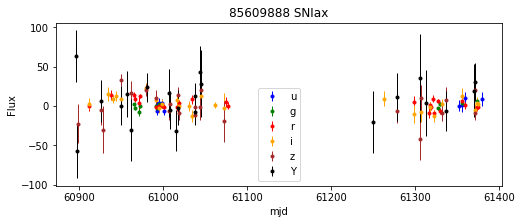

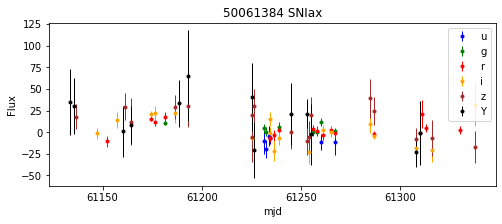

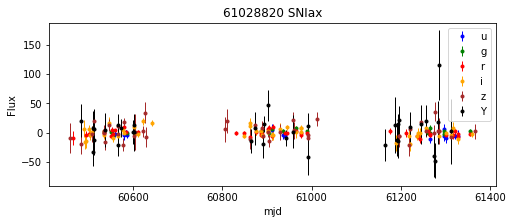

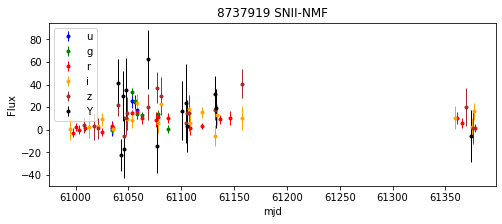

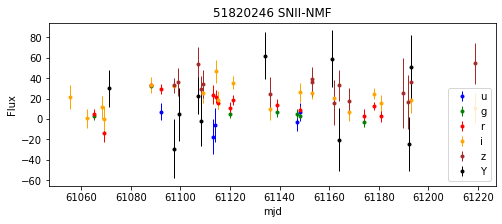

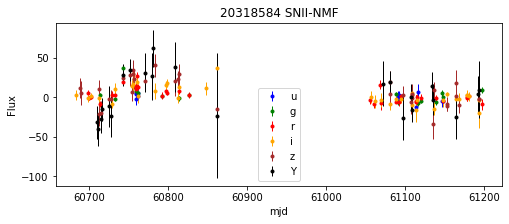

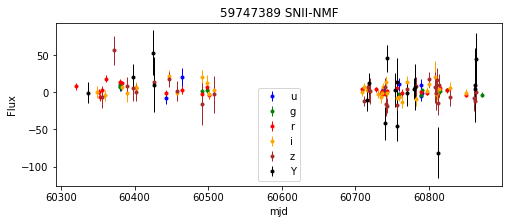

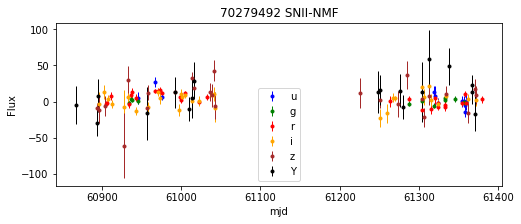

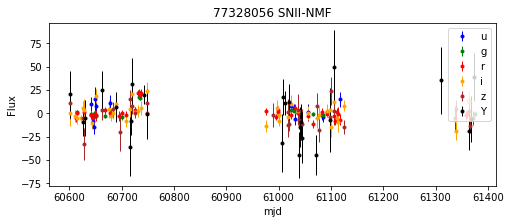

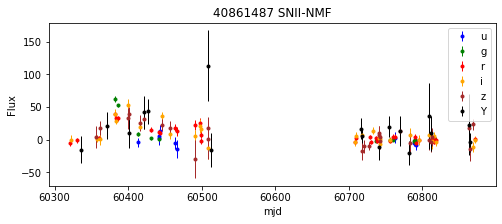

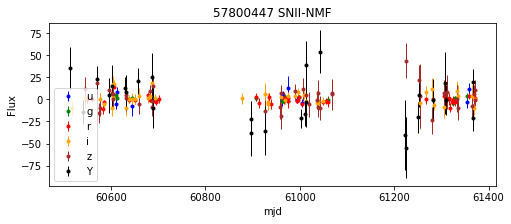

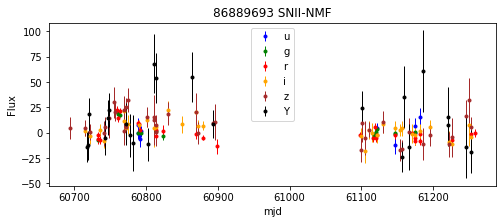

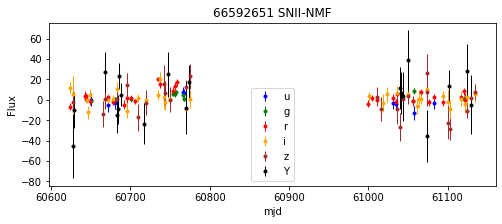

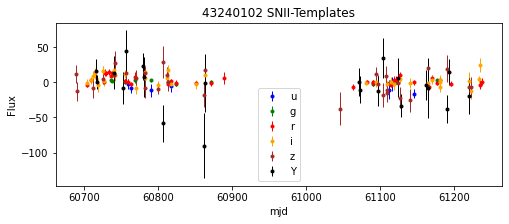

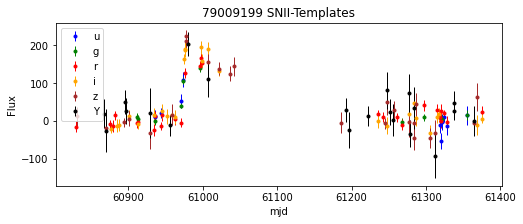

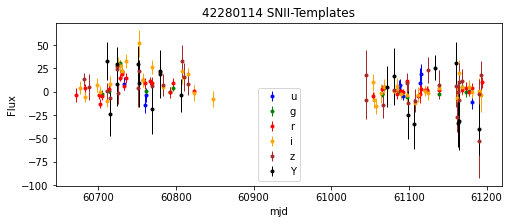

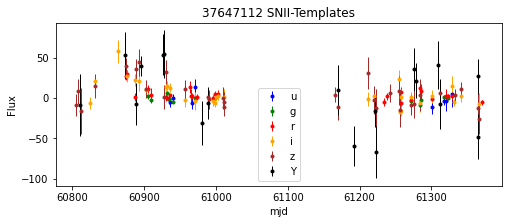

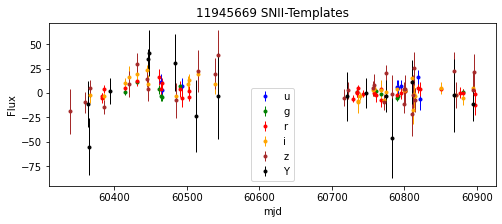

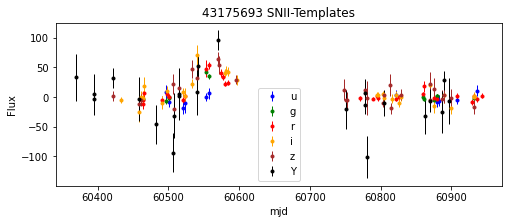

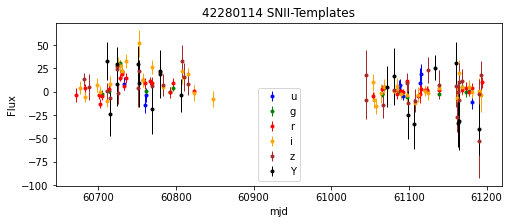

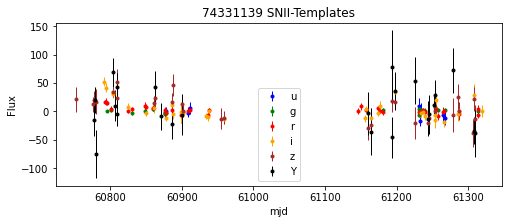

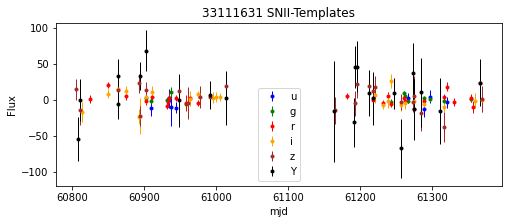

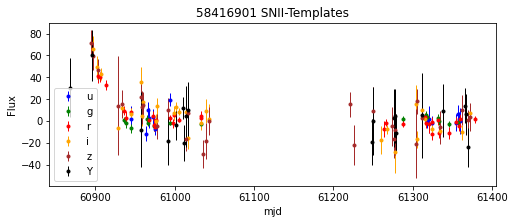

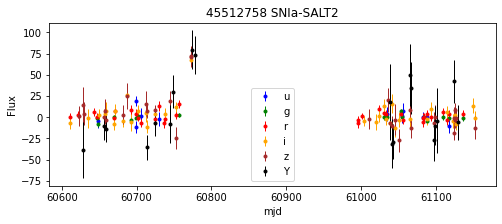

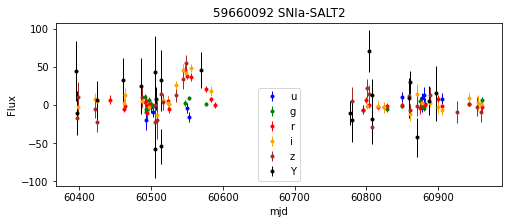

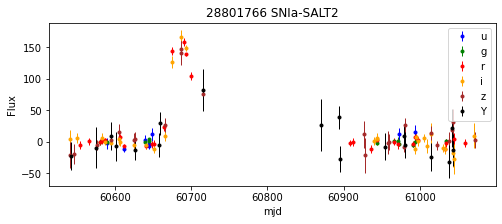

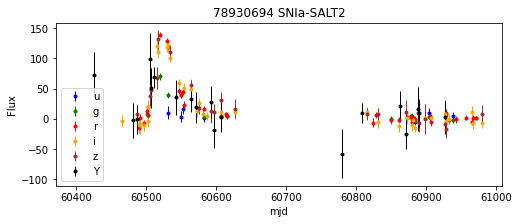

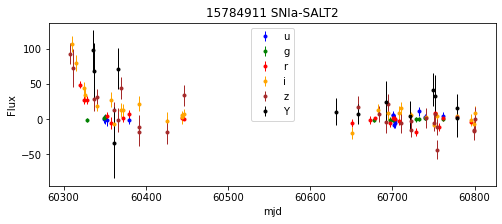

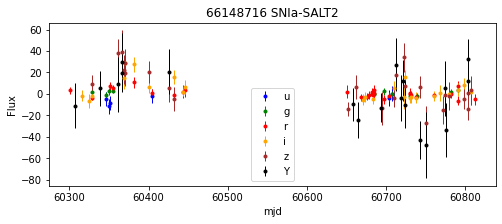

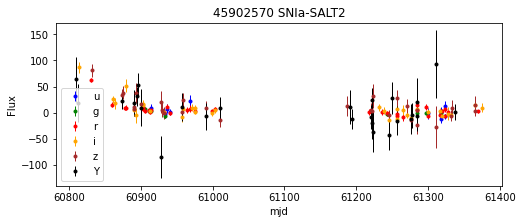

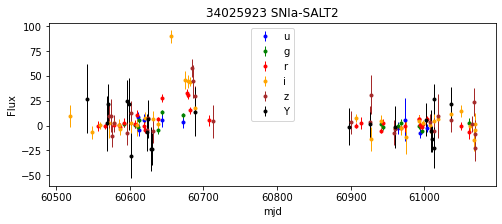

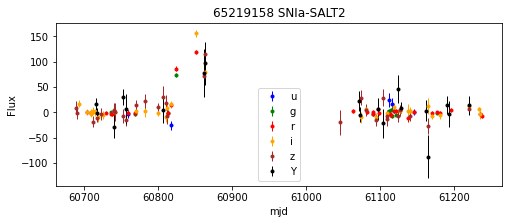

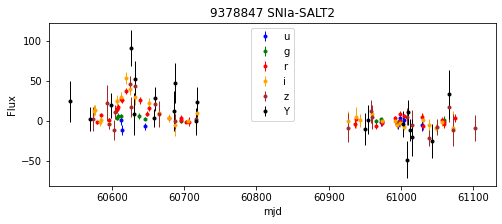

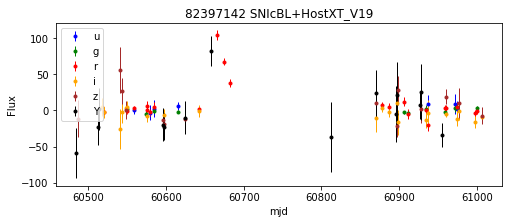

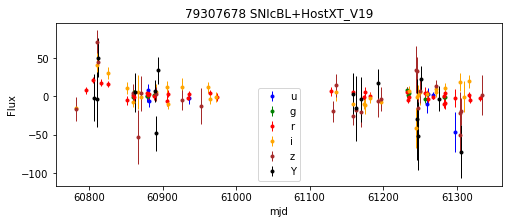

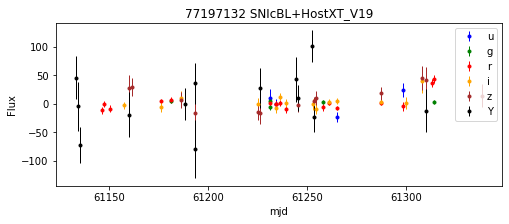

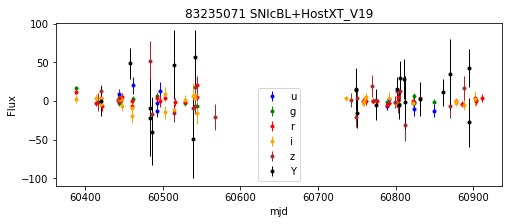

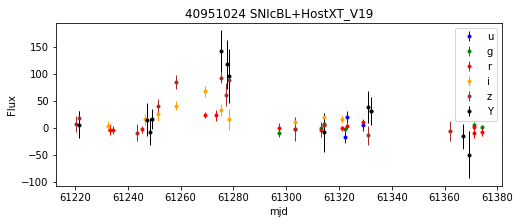

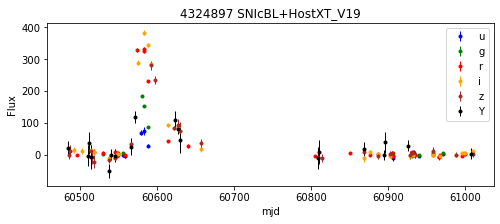

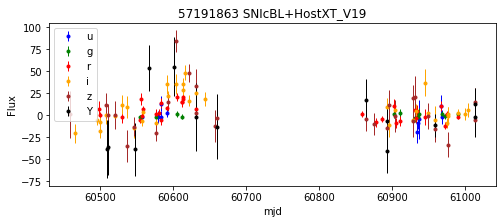

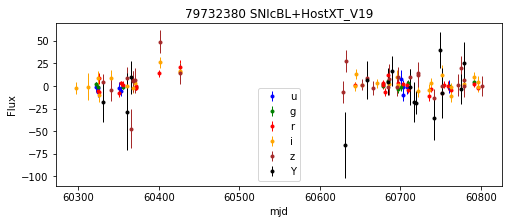

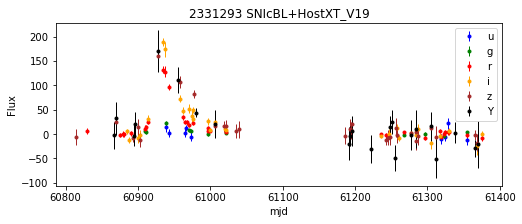

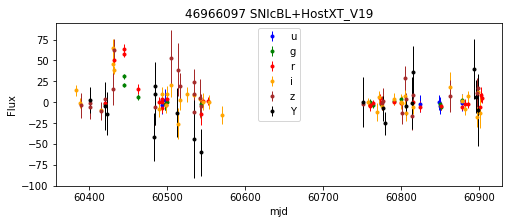

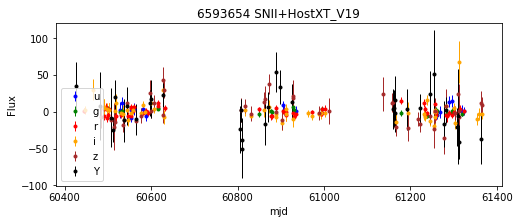

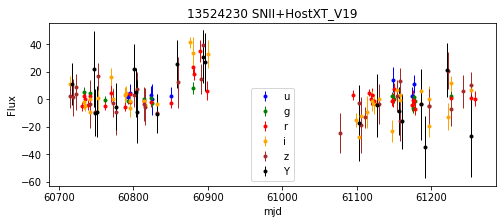

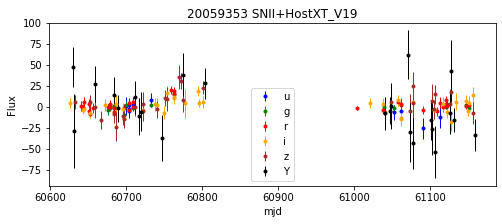

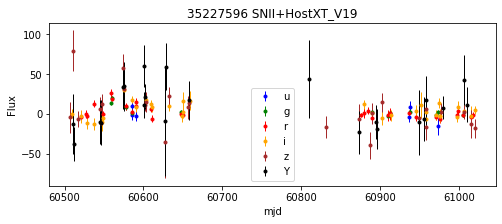

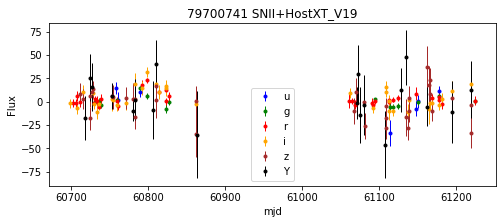

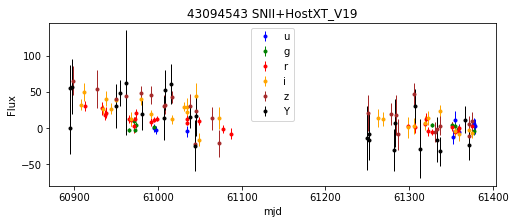

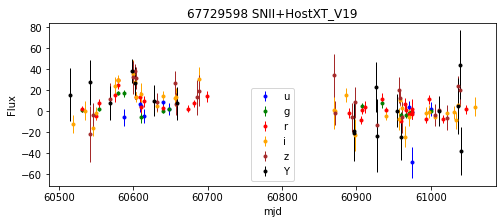

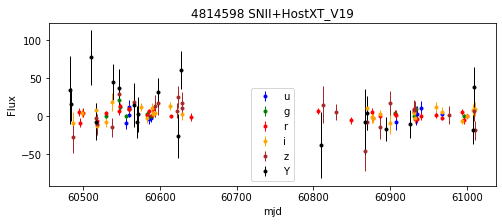

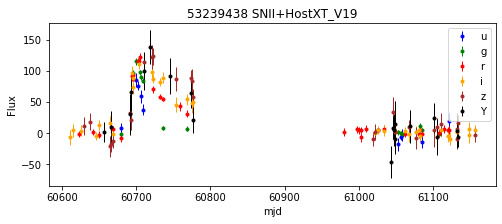

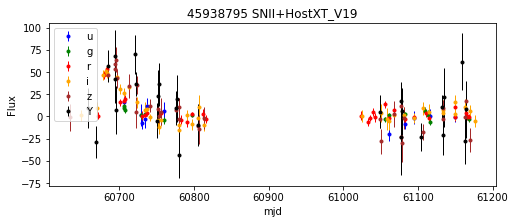

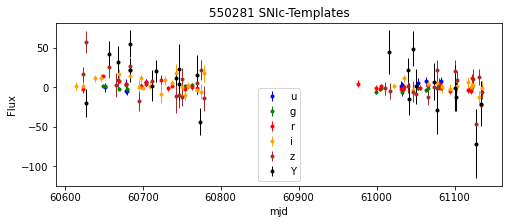

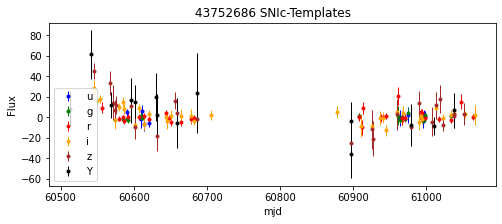

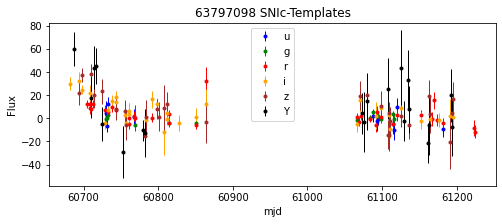

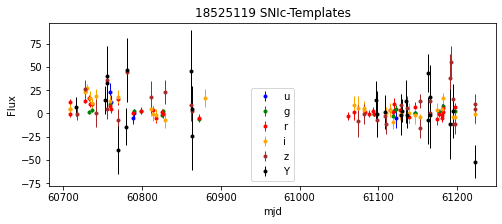

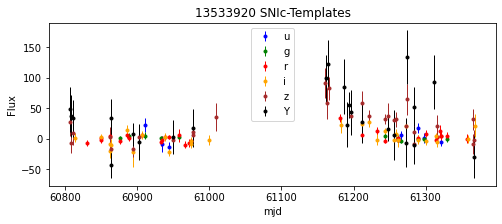

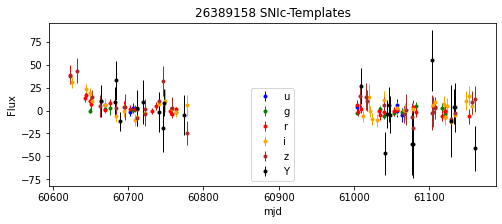

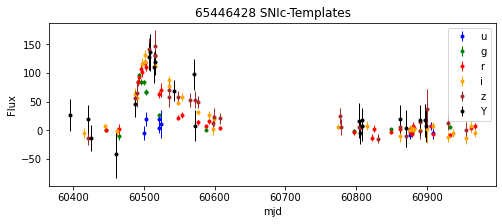

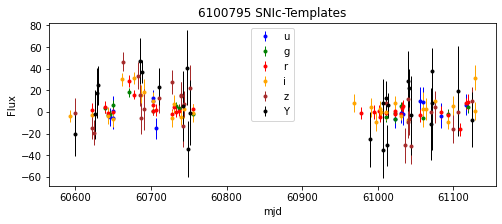

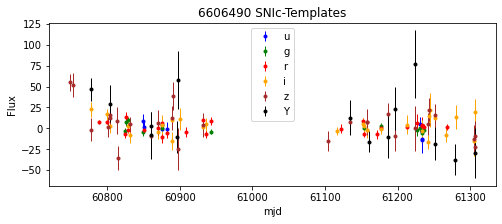

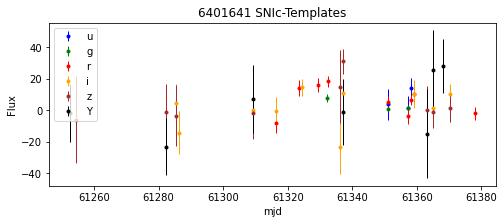

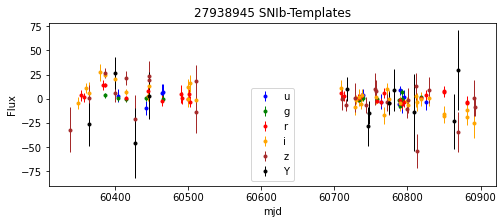

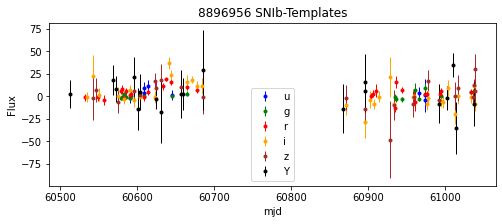

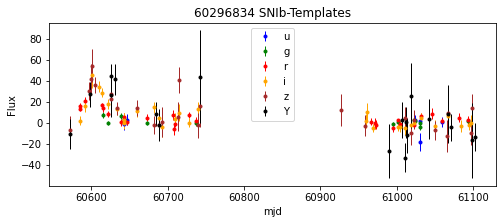

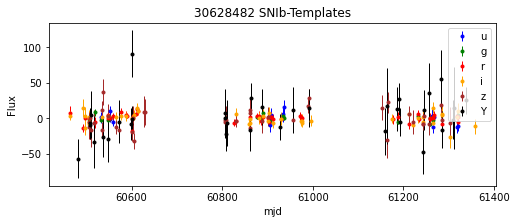

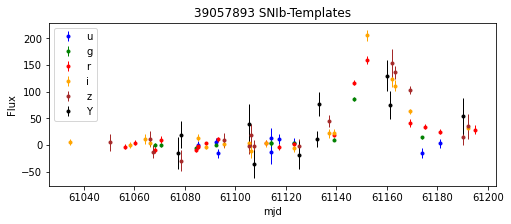

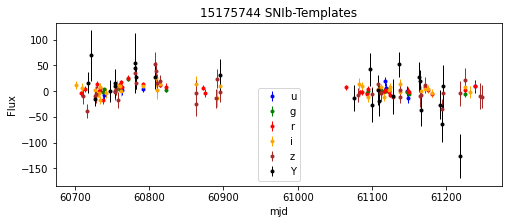

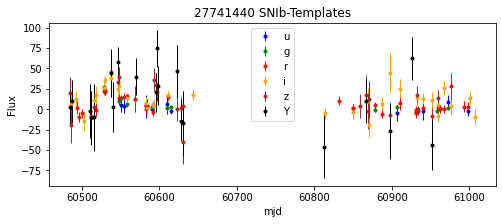

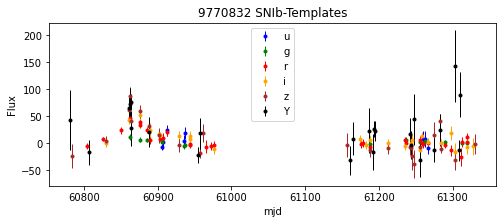

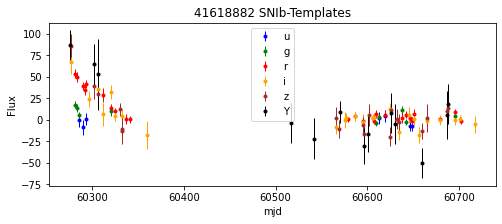

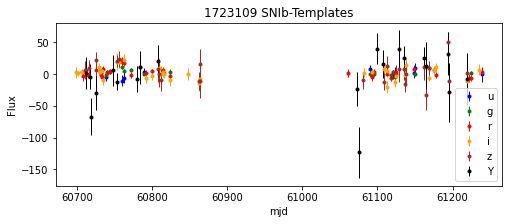

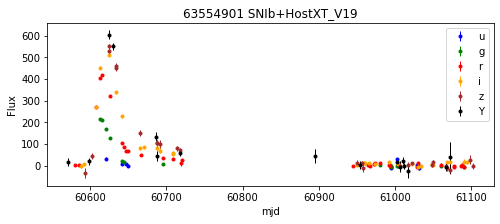

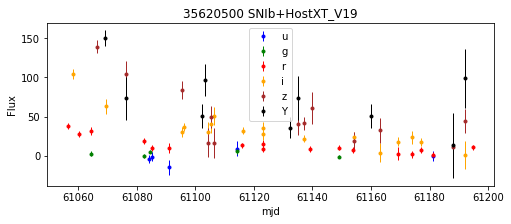

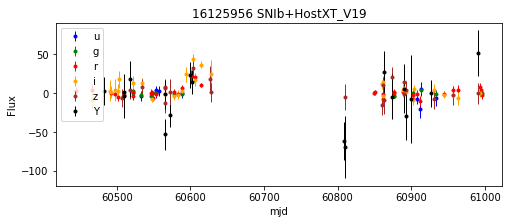

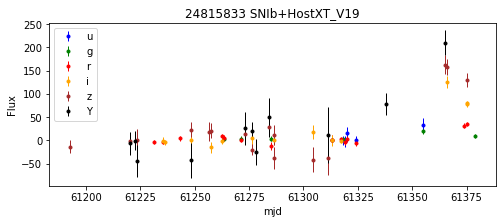

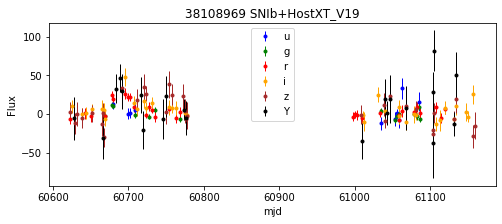

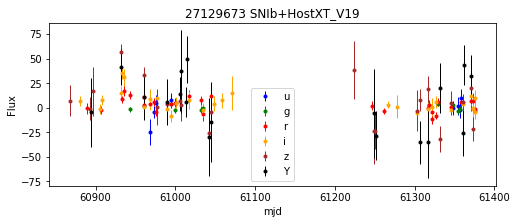

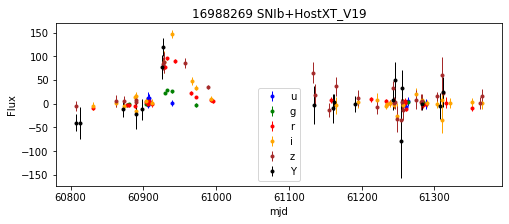

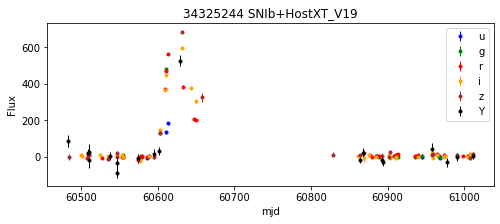

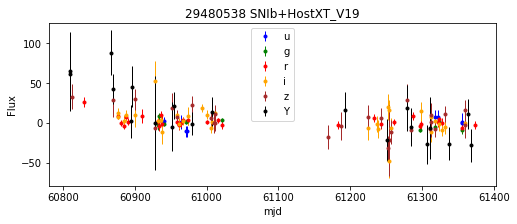

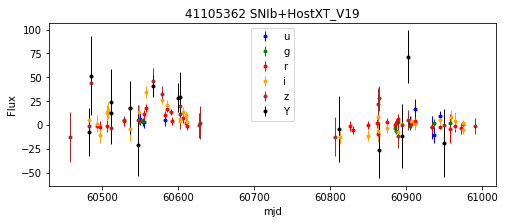

In [10]:
for snid in snids:
    plot_lc(str(snid), df_train, path='images/lightcurves/')
    plt.show()

In [11]:
alert_name = ['SNID', 'RA', 'DEC', 'NOBS', 'MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_SPECZ',
            'HOSTGAL_SPECZ_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_ZPHOT_Q000', 'HOSTGAL_ZPHOT_Q010', 'HOSTGAL_ZPHOT_Q020', 'HOSTGAL_ZPHOT_Q030',
            'HOSTGAL_ZPHOT_Q040', 'HOSTGAL_ZPHOT_Q050', 'HOSTGAL_ZPHOT_Q060', 'HOSTGAL_ZPHOT_Q070', 'HOSTGAL_ZPHOT_Q080', 'HOSTGAL_ZPHOT_Q090', 'HOSTGAL_ZPHOT_Q100',
            'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r',
            'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y','HOSTGAL2_RA', 'HOSTGAL2_DEC', 'HOSTGAL2_SNSEP', 'HOSTGAL2_SPECZ', 'HOSTGAL2_SPECZ_ERR', 'HOSTGAL2_PHOTOZ',
            'HOSTGAL2_PHOTOZ_ERR', 'HOSTGAL2_ZPHOT_Q000', 'HOSTGAL2_ZPHOT_Q010', 'HOSTGAL2_ZPHOT_Q020', 'HOSTGAL2_ZPHOT_Q030',  'HOSTGAL2_ZPHOT_Q040', 'HOSTGAL2_ZPHOT_Q050',
            'HOSTGAL2_ZPHOT_Q060', 'HOSTGAL2_ZPHOT_Q070', 'HOSTGAL2_ZPHOT_Q080', 'HOSTGAL2_ZPHOT_Q090', 'HOSTGAL2_ZPHOT_Q100', 'HOSTGAL2_MAG_u', 'HOSTGAL2_MAG_g',
            'HOSTGAL2_MAG_r', 'HOSTGAL2_MAG_i', 'HOSTGAL2_MAG_z', 'HOSTGAL2_MAG_Y', 'HOSTGAL2_MAGERR_u', 'HOSTGAL2_MAGERR_g', 'HOSTGAL2_MAGERR_r', 'HOSTGAL2_MAGERR_i',
            'HOSTGAL2_MAGERR_z', 'HOSTGAL2_MAGERR_Y', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']

In [12]:
df_alert = df_train[alert_name]
df_alert

,SNID,RA,DEC,NOBS,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_MAGERR_Y,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,MJD,BAND,FLUXCAL,FLUXCALERR
0,27528421,64.849535,-14.710349,117,0.035791,0.001790,0.423353,0.03838,64.848976,-14.710298,0.756289,-9.0,-9.0,0.423353,0.03838,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60895.4269,Y,-27.043575,33.173176
1,27528421,64.849535,-14.710349,117,0.035791,0.001790,0.423353,0.03838,64.848976,-14.710298,0.756289,-9.0,-9.0,0.423353,0.03838,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60896.4165,Y,-24.575598,36.923645
2,27528421,64.849535,-14.710349,117,0.035791,0.001790,0.423353,0.03838,64.848976,-14.710298,0.756289,-9.0,-9.0,0.423353,0.03838,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60927.4045,z,-9.708896,18.190941
3,27528421,64.849535,-14.710349,117,0.035791,0.001790,0.423353,0.03838,64.848976,-14.710298,0.756289,-9.0,-9.0,0.423353,0.03838,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60937.3783,r,4.829184,5.221447
4,27528421,64.849535,-14.710349,117,0.035791,0.001790,0.423353,0.03838,64.848976,-14.710298,0.756289,-9.0,-9.0,0.423353,0.03838,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60944.3744,i,6.980536,3.225589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [13]:
df_alert.loc[df_alert['HOSTGAL_MAG_u'] == 999]

,SNID,RA,DEC,NOBS,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_MAGERR_Y,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,MJD,BAND,FLUXCAL,FLUXCALERR
1459,56546163,58.502896,-6.388586,45,0.081088,0.004054,0.235270,0.03333,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,61250.4378,z,10.938726,26.199944
1460,56546163,58.502896,-6.388586,45,0.081088,0.004054,0.235270,0.03333,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,61251.4241,Y,-10.148694,29.011076
1461,56546163,58.502896,-6.388586,45,0.081088,0.004054,0.235270,0.03333,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,61252.4301,Y,27.523014,26.883640
1462,56546163,58.502896,-6.388586,45,0.081088,0.004054,0.235270,0.03333,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,61262.4357,i,3.107204,11.088252
1463,56546163,58.502896,-6.388586,45,0.081088,0.004054,0.235270,0.03333,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,61278.4160,z,-2.930198,17.629837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282117,60196573,357.132851,-40.411364,73,0.010915,0.000546,0.323273,0.00100,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0